### Setting

In [ ]:
import os
import json
import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from utils.metrics import encode_mask_to_rle
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
IMAGE_ROOT = "/data/ephemeral/home/data/train/DCM"
LABEL_ROOT = "/data/ephemeral/home/data/train/outputs_json"
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]
CLASS2IND = {v: i for i, v in enumerate(CLASSES)}
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

IMAGE_SHAPE = (2048, 2048, 3) # 모든 이미지 : (2048, 2048, 3)
NUM_CLASSES = len(CLASSES)
    
# 3 colors
colors = ['#08F2E7' for i in range(19)]
colors.extend(['#68FE02' for i in range(8)])
colors.extend(['#FF0101' for i in range(2)])

# 29 colors
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]
PALETTE_HEX = [f'#{r:02x}{g:02x}{b:02x}' for r, g, b in PALETTE]

In [ ]:
def group_parts(x):
    if x in range(0, 3): 
        return 0
    elif x in range(3, 7):
        return 1
    elif x in range(7, 11):
        return 2
    elif x in range(11, 15):
        return 3
    elif x in range(15, 19):
        return 4
    elif x in range(19, 27):
        return 5
    elif x in range(27, 29):
        return 6
    else:
        return 7

# 시각화 함수입니다. 클래스가 2개 이상인 픽셀을 고려하지는 않습니다.
def create_gt_mask(label_path, image_shape):
    # GT 마스크의 shape 생성 (높이, 너비, 클래스 수)
    label_shape = (image_shape[0], image_shape[1], len(CLASSES))
    label = np.zeros(label_shape, dtype=np.uint8)
    
    # JSON 레이블 파일 열기
    with open(label_path, "r") as f:
        annotations = json.load(f)
    annotations = annotations["annotations"]
    
    # 클래스별로 마스크 생성
    for ann in annotations:
        c = ann["label"]
        class_ind = CLASS2IND[c]
        points = np.array(ann["points"])
        
        # 각 클래스 마스크 생성 및 할당
        class_label = np.zeros(image_shape[:2], dtype=np.uint8)
        cv2.fillPoly(class_label, [points], 1)
        label[..., class_ind] = class_label
    
    # 채널 순서 변경 (H, W, C) -> (C, H, W)
    label = label.transpose(2, 0, 1)
    
    return label

def label2rgb(label):
    image_shape = label.shape[1:] + (3, )
    image = np.zeros(image_shape, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

def visualize_segmentation(id):
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    image_id_path = os.path.join(IMAGE_ROOT, id)
    label_id_path = os.path.join(LABEL_ROOT, id)

    image_list = os.listdir(image_id_path)

    for i, image in enumerate(image_list):
        image_path = os.path.join(image_id_path, image)
        label_path = os.path.join(label_id_path, image.split('.')[0], '.json')
        
        img = cv2.imread(image_path)
        axes[i, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        gt_mask = create_gt_mask(label_path, IMAGE_SHAPE)
        axes[i, 1].imshow(label2rgb(gt_mask))
    fig.suptitle(id)
    plt.tight_layout()

In [ ]:
# Get data name
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}
jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}
# 이름 순 정렬
pngs = sorted(pngs)
jsons = sorted(jsons)

print('png len :', len(pngs))
print('json len :', len(jsons))

png len : 800
json len : 800


### Load Data

In [ ]:
# EDA를 위한 label_rle load(약 8분 소요)
labels_rle = dict()

for label_name in jsons:
    label_path = os.path.join(LABEL_ROOT, label_name)
    with open(label_path, "r") as f:
        annotations = json.load(f)["annotations"]
    
    id_name = label_name.split('.')[0]
    labels_rle[id_name] = dict()
    for ann in annotations:
        c = ann["label"] # class 이름
        points = np.array(ann["points"])
        class_label = np.zeros(IMAGE_SHAPE[:2], dtype=np.uint8)
        cv2.fillPoly(class_label, [points], 1)
        labels_rle[id_name][c] = encode_mask_to_rle(class_label)

### Create Base Dataframe

In [38]:
# Area dataframe 
result = []
for key, values in labels_rle.items():
    # 'ID'와 'name'을 분리
    ID, name = key.split('/')
    
    row = {'ID': ID, 'name': name}
    total_area = 0
    for c in CLASSES:
        sub_key = c
        numbers = values[c]
        numbers = list(map(int, numbers.split()))
        area_sum = sum(numbers[1::2])
        row[f'{sub_key}_area'] = area_sum # 홀수 인덱스만 추출하여 합계 계산
        total_area += area_sum
    row['total_area'] = total_area
    
    result.append(row)

df = pd.DataFrame(result)
df.head()

,ID,name,finger-1_area,finger-2_area,finger-3_area,finger-4_area,finger-5_area,finger-6_area,finger-7_area,finger-8_area,...,Trapezoid_area,Capitate_area,Hamate_area,Scaphoid_area,Lunate_area,Triquetrum_area,Pisiform_area,Radius_area,Ulna_area,total_area
0,ID001,image1661130828152_R,6201,14075,22104,4456,9247,20082,31868,5462,...,5839,15590,8904,9206,6448,5279,3113,75188,45046,458681
1,ID001,image1661130891365_L,6550,13623,22512,4258,8529,19142,31313,5334,...,4982,14386,10883,8615,7090,6604,2728,71766,38750,447042
2,ID002,image1661144206667,8034,17905,30292,5448,11397,23493,37849,6744,...,7028,16772,12153,12954,9274,8894,3902,71969,34994,528580
3,ID002,image1661144246917,7683,17150,30464,5297,10962,23117,36643,6684,...,8231,16160,13779,11863,8570,8284,4285,68798,34143,518961
4,ID003,image1661144310162,5312,12094,19645,3885,7928,18048,29206,4194,...,4002,11511,9235,8396,5904,5201,3522,65473,35942,395390


### Analyze Area Ratio Distribution

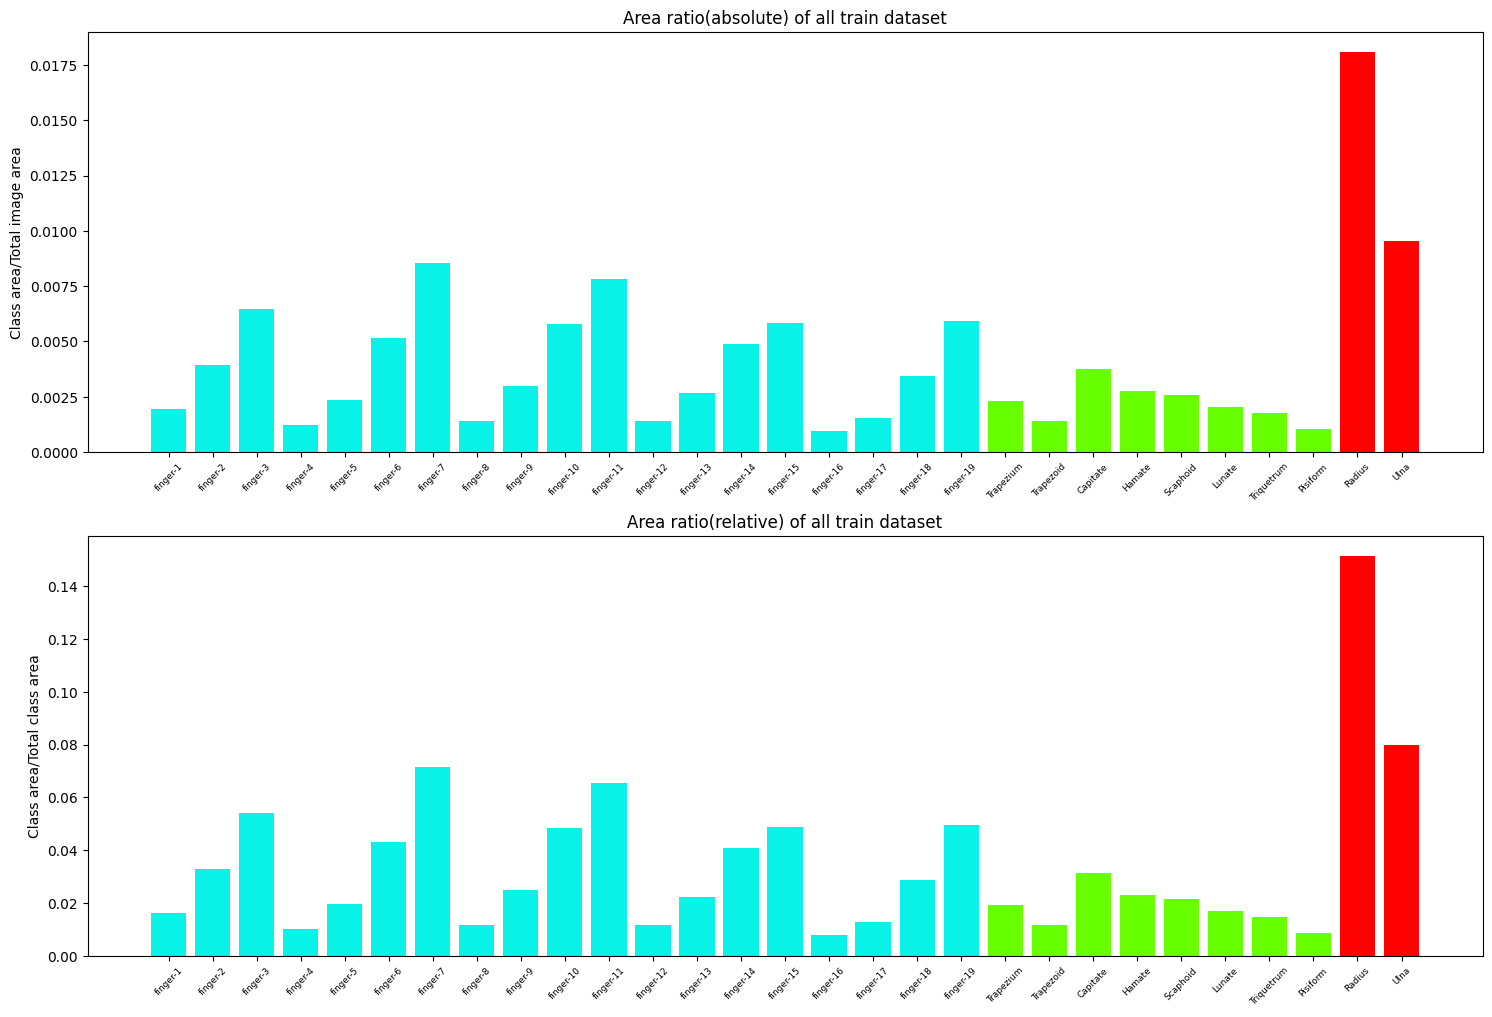

In [496]:
# Area ratio 비교(전체 data의 모든 area를 합쳐서 계산)
area_ratio_a_all = df.iloc[:, 2:-1].sum(axis=0) / ((2048 * 2048) * len(df))
area_ratio_r_all = df.iloc[:, 2:-1].sum(axis=0) / df.iloc[:,-1].sum(axis=0)

fig, axes = plt.subplots(2, 1, figsize=(18, 12))
axes[0].bar(range(len(area_ratio_a_all)), area_ratio_a_all, color=colors)
axes[0].set_title('Area ratio(absolute) of all train dataset')
axes[0].set_xticks(range(len(area_ratio_a_all)), CLASSES, rotation=45, fontdict={'size': 6.5})
axes[0].set_ylabel('Class area/Total image area')

axes[1].bar(range(len(area_ratio_r_all)), area_ratio_r_all, color=colors)
axes[1].set_title('Area ratio(relative) of all train dataset')
axes[1].set_xticks(range(len(area_ratio_r_all)), CLASSES, rotation=45, fontdict={'size': 6.5})
axes[1].set_ylabel('Class area/Total class area')

plt.show()

In [497]:
# Area ratio dataframe(개별 data의 area ratio 계산(%))
df_new = df.loc[:, ['ID', 'name']]
for c in CLASSES:
    df_new[f'{c}_ratio'] = df[f'{c}_area'] / (2048 * 2048) * 100
df_new['total_ratio'] = df['total_area'] / (2048 * 2048) * 100
df_new.head()

,ID,name,finger-1_ratio,finger-2_ratio,finger-3_ratio,finger-4_ratio,finger-5_ratio,finger-6_ratio,finger-7_ratio,finger-8_ratio,...,Trapezoid_ratio,Capitate_ratio,Hamate_ratio,Scaphoid_ratio,Lunate_ratio,Triquetrum_ratio,Pisiform_ratio,Radius_ratio,Ulna_ratio,total_ratio
0,ID001,image1661130828152_R,0.147843,0.335574,0.527000,0.106239,0.220466,0.478792,0.759792,0.130224,...,0.139213,0.371695,0.212288,0.219488,0.153732,0.125861,0.074220,1.792622,1.073980,10.935807
1,ID001,image1661130891365_L,0.156164,0.324798,0.536728,0.101519,0.203347,0.456381,0.746560,0.127172,...,0.118780,0.342989,0.259471,0.205398,0.169039,0.157452,0.065041,1.711035,0.923872,10.658312
2,ID002,image1661144206667,0.191545,0.426888,0.722218,0.129890,0.271726,0.560117,0.902390,0.160789,...,0.167561,0.399876,0.289750,0.308847,0.221109,0.212049,0.093031,1.715875,0.834322,12.602329
3,ID002,image1661144246917,0.183177,0.408888,0.726318,0.126290,0.261354,0.551152,0.873637,0.159359,...,0.196242,0.385284,0.328517,0.282836,0.204325,0.197506,0.102162,1.640272,0.814033,12.372994
4,ID003,image1661144310162,0.126648,0.288343,0.468373,0.092626,0.189018,0.430298,0.696325,0.099993,...,0.095415,0.274444,0.220180,0.200176,0.140762,0.124002,0.083971,1.560998,0.856924,9.426832


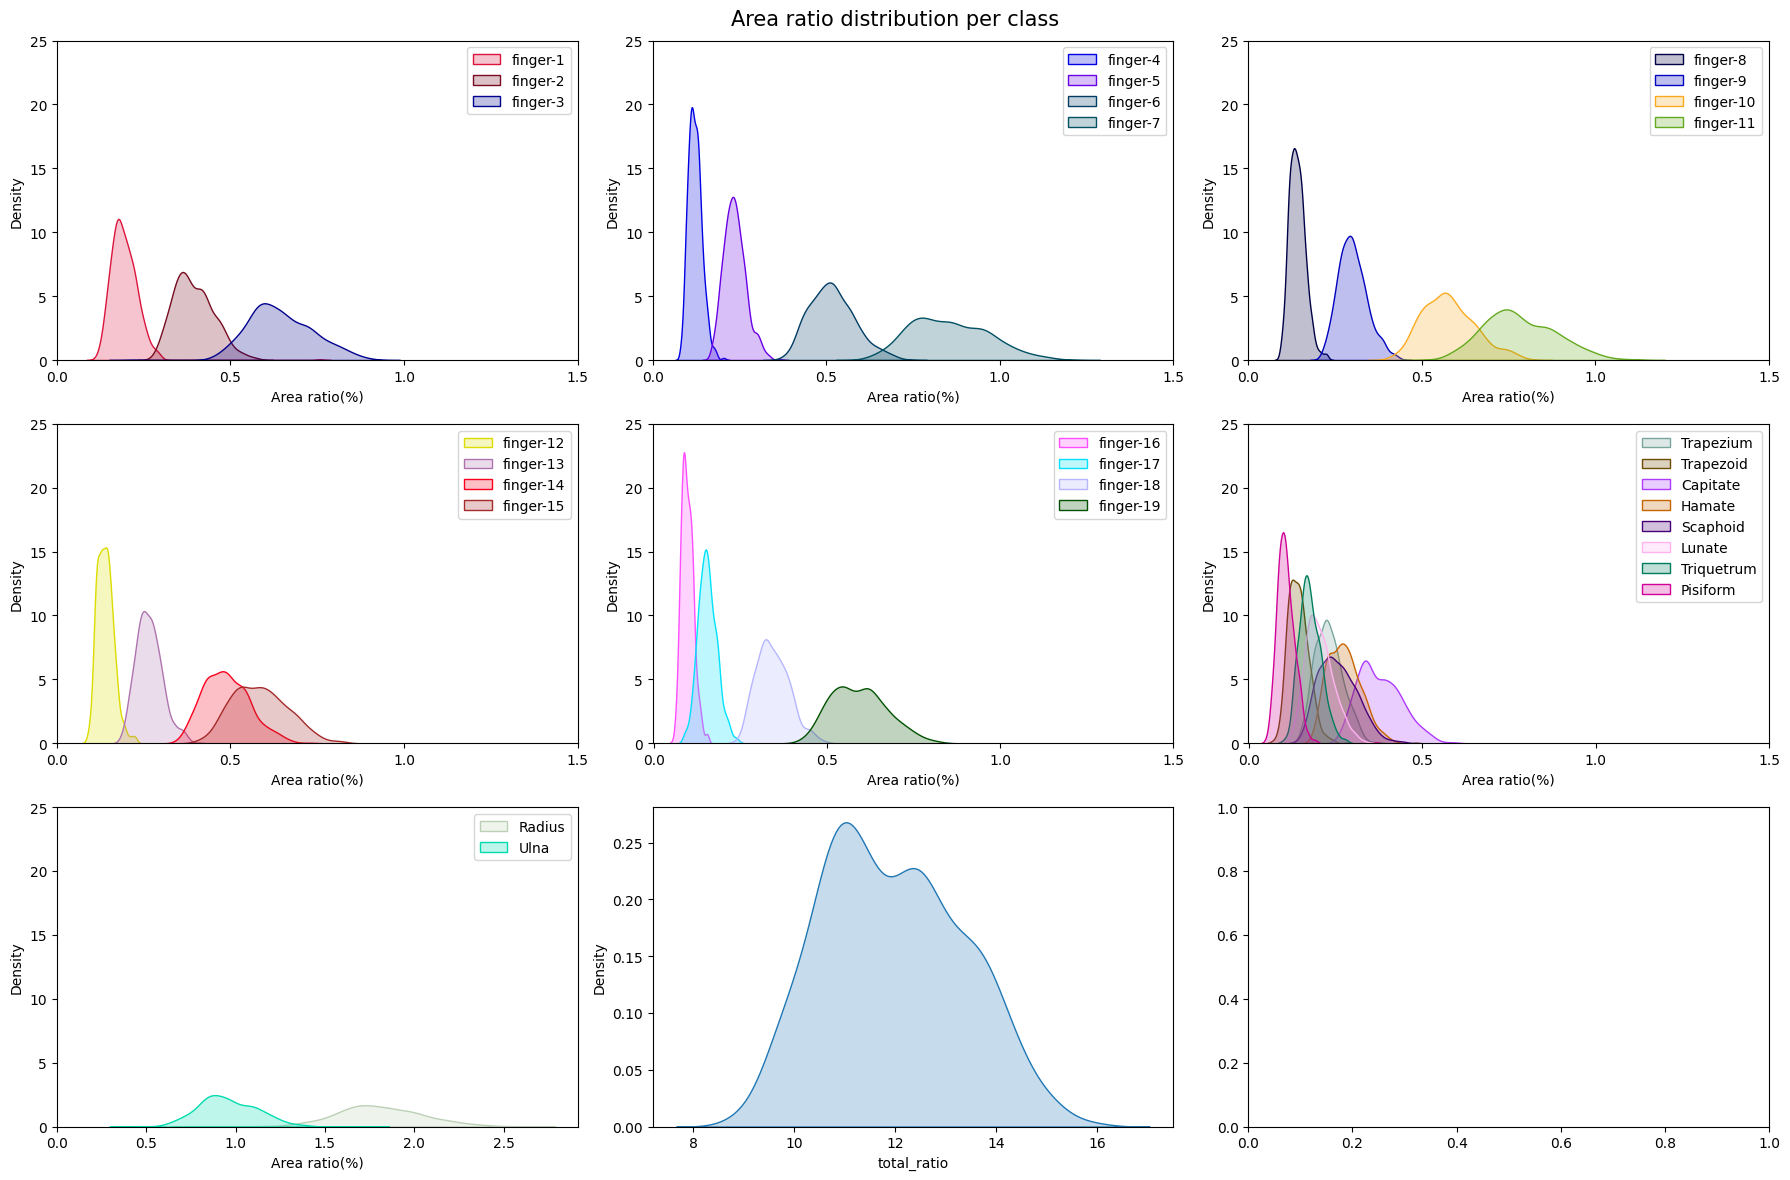

In [499]:
# Area ratio distribution per class(kdeplot)
area_df = df_new.iloc[:,2:]
label_total = CLASSES + ['total']

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()
for i in range(area_df.shape[1]-1):
    column = area_df.columns[i]
    ax = axes[group_parts(i)]
    sns.kdeplot(x=column, data=area_df, label=label_total[i], color=PALETTE_HEX[i], fill=True, ax=ax)
    ax.set_xlabel('Area ratio(%)')
    if i >= 27:
        ax.set_xticks([0, 0.5, 1.0, 1.5, 2.0, 2.5])
    else:
        ax.set_xticks([0, 0.5, 1.0, 1.5])
    ax.set_yticks([0, 5, 10, 15, 20, 25])
    ax.legend()
sns.kdeplot(x='total_ratio', data=area_df, label='total', fill=True, ax = axes[-2])
fig.suptitle('Area ratio distribution per class', size=15)
plt.tight_layout()
plt.show()

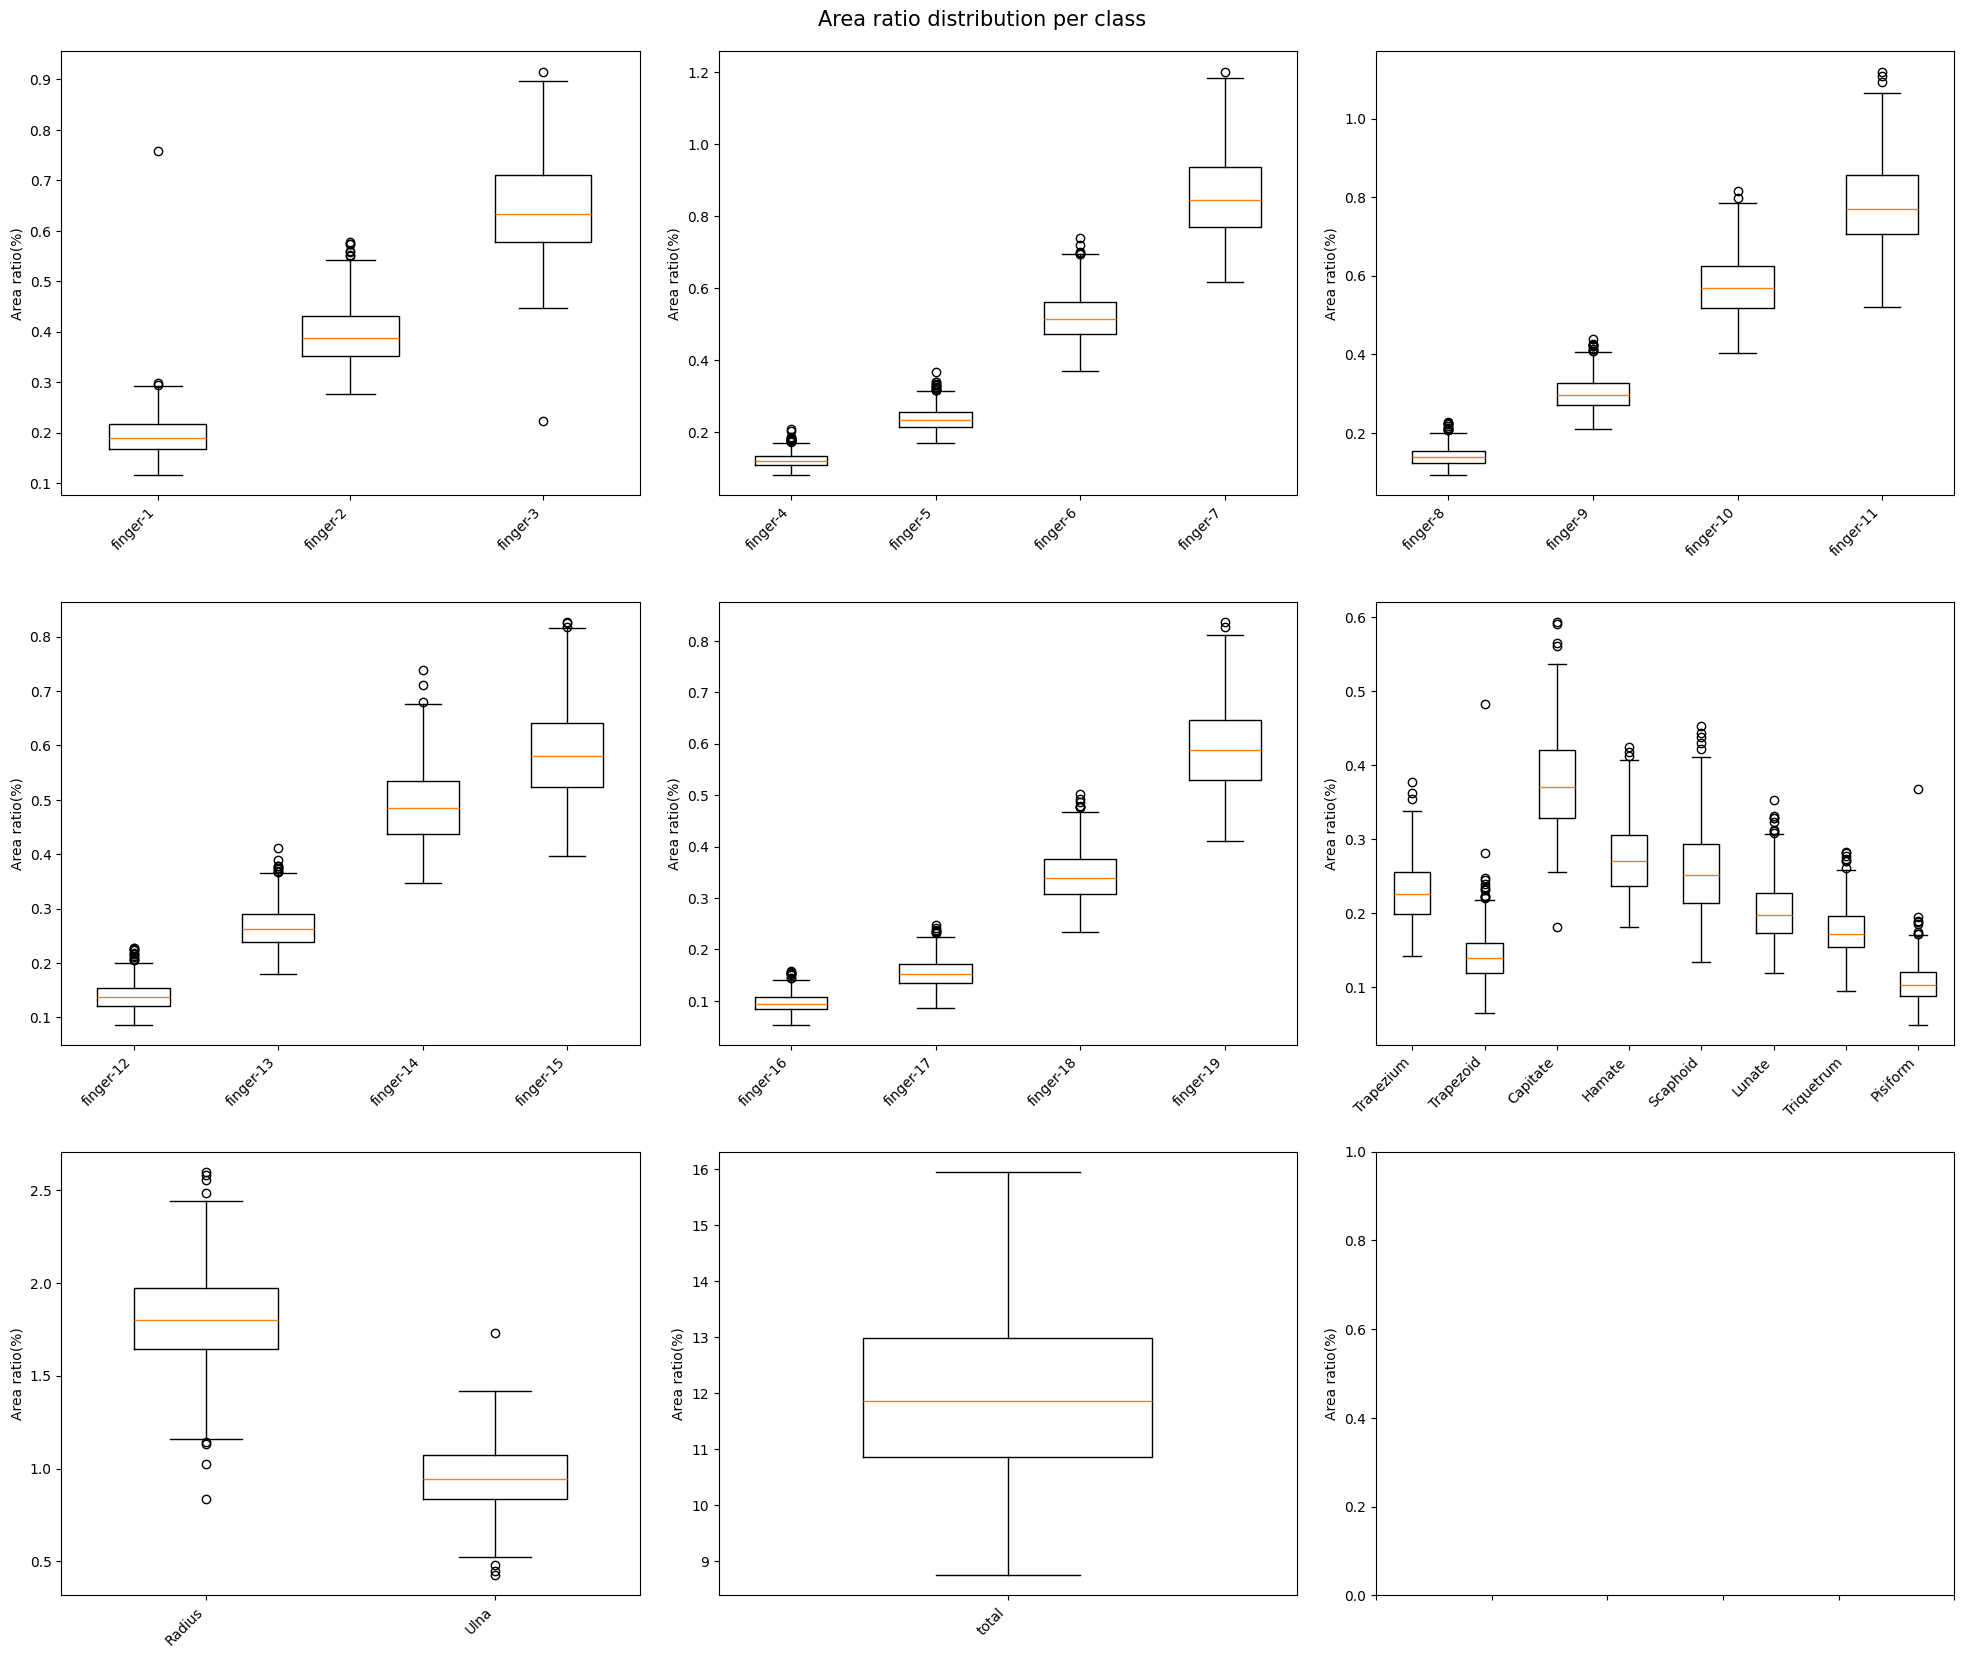

In [500]:
# Area ratio distribution per class(boxplot)
fig, axes = plt.subplots(3, 3, figsize=(20, 17))
axes = axes.flatten()
group_labels = [[] for _ in range(9)]
for i in range(area_df.shape[1]):
    group = group_parts(i)  # group_parts 함수를 사용하여 그룹 번호 계산
    col_position = sum([group_parts(j) == group for j in range(i)])  # 같은 그룹 내에서 가로 위치 지정
    axes[group].boxplot(area_df.iloc[:, i], positions=[col_position],widths=0.5)  # 그룹에 맞는 서브플롯에 가로로 배치
    group_labels[group].append(label_total[i])

for group, ax in enumerate(axes):
    ax.set_ylabel('Area ratio(%)')
    ax.set_xticklabels(group_labels[group], rotation=45, ha='right')  # x축 레이블 설정 및 회전
    
fig.suptitle('Area ratio distribution per class', size=15)
plt.tight_layout(pad=2)
plt.show()

In [ ]:
# 이상치 찾기
df_new[(df_new['finger-1_ratio'] > 0.5)]

,ID,name,finger-1_ratio,finger-2_ratio,finger-3_ratio,finger-4_ratio,finger-5_ratio,finger-6_ratio,finger-7_ratio,finger-8_ratio,...,Trapezoid_ratio,Capitate_ratio,Hamate_ratio,Scaphoid_ratio,Lunate_ratio,Triquetrum_ratio,Pisiform_ratio,Radius_ratio,Ulna_ratio,total_ratio
95,ID058,image1661392103627,0.758076,0.459409,0.222588,0.13423,0.276542,0.591683,0.943065,0.158453,...,0.481868,0.181127,0.24333,0.198674,0.155544,0.244856,0.36695,0.83456,1.730657,13.44533


In [ ]:
visualize_segmentation('ID058')

### Add Meta Data

In [ ]:
# Meta_data dataframe
meta = pd.read_excel("/data/ephemeral/home/meta_data.xlsx")
meta.head()

,ID,나이,성별,체중(몸무게),키(신장),Unnamed: 5
0,1,30,_x0008_여,63.0,165.0,NaN
1,2,21,_x0008_남,70.0,172.0,NaN
2,3,21,_x0008_여,48.0,164.0,NaN
3,4,30,_x0008_여,49.0,158.0,NaN
4,5,33,_x0008_여,50.0,160.0,NaN


In [ ]:
# meta dataframe 포맷 변경
meta_new = pd.DataFrame()
meta_new['ID'] = meta['ID'].apply(lambda x: f'ID{int(x):03d}')
meta_new['age'] = meta['나이']
meta_new['gender'] = meta['성별'].apply(lambda x: 0 if '여' in x else 1)
meta_new['weight'] = meta['체중(몸무게)']
meta_new['height'] = meta['키(신장)']

# 두 데이터프레임 병합 (ID 기준으로)
merged_df = pd.merge(df_new, meta_new, on='ID', how='left')
merged_df.head()

,ID,name,finger-1_ratio,finger-2_ratio,finger-3_ratio,finger-4_ratio,finger-5_ratio,finger-6_ratio,finger-7_ratio,finger-8_ratio,...,Lunate_ratio,Triquetrum_ratio,Pisiform_ratio,Radius_ratio,Ulna_ratio,total_ratio,age,gender,weight,height
0,ID001,image1661130828152_R,0.147843,0.335574,0.527000,0.106239,0.220466,0.478792,0.759792,0.130224,...,0.153732,0.125861,0.074220,1.792622,1.073980,10.935807,30,0,63.0,165.0
1,ID001,image1661130891365_L,0.156164,0.324798,0.536728,0.101519,0.203347,0.456381,0.746560,0.127172,...,0.169039,0.157452,0.065041,1.711035,0.923872,10.658312,30,0,63.0,165.0
2,ID002,image1661144206667,0.191545,0.426888,0.722218,0.129890,0.271726,0.560117,0.902390,0.160789,...,0.221109,0.212049,0.093031,1.715875,0.834322,12.602329,21,1,70.0,172.0
3,ID002,image1661144246917,0.183177,0.408888,0.726318,0.126290,0.261354,0.551152,0.873637,0.159359,...,0.204325,0.197506,0.102162,1.640272,0.814033,12.372994,21,1,70.0,172.0
4,ID003,image1661144310162,0.126648,0.288343,0.468373,0.092626,0.189018,0.430298,0.696325,0.099993,...,0.140762,0.124002,0.083971,1.560998,0.856924,9.426832,21,0,48.0,164.0


### Analyze Correlation

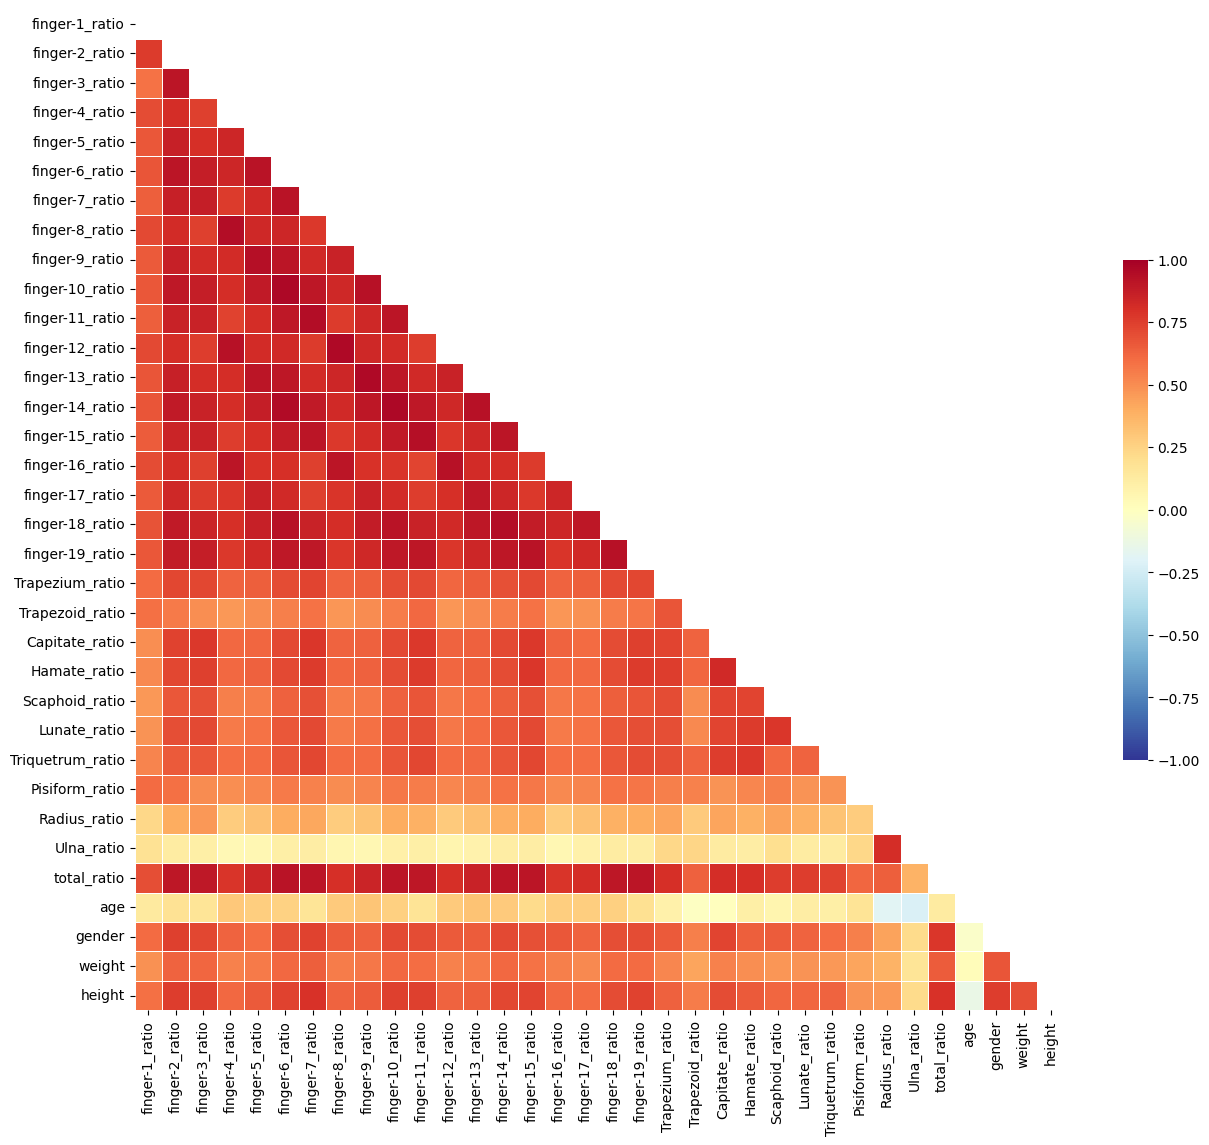

In [ ]:
# Numeric Dataframe
numeric_df = merged_df.select_dtypes(include=[float, int])
matrix = numeric_df.corr()

fig, ax = plt.subplots(figsize=(15,13))

mask = np.zeros_like(matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(matrix, 
            cmap = 'RdYlBu_r', 
            annot = False,
            mask = mask,
            linewidths=.5,
            cbar_kws={"shrink": .5},
            vmin = -1,vmax = 1
           )
plt.show()

In [ ]:
def visualize_per_meta(meta):
    meta_df = pd.concat([numeric_df.iloc[:, :30], numeric_df.loc[:, meta]], axis=1)
    meta_df.columns = CLASSES + ['total', meta]
    meta_matrix = meta_df.corr()

    fig, ax = plt.subplots(figsize=(2,8))
    sns.heatmap(pd.DataFrame(meta_matrix.loc[meta,:]), 
                cmap = 'RdYlBu_r', 
                annot = True,
                linewidths=.5, 
                vmin = -1,vmax = 1 
            )
    plt.yticks(fontsize=9)
    plt.show()

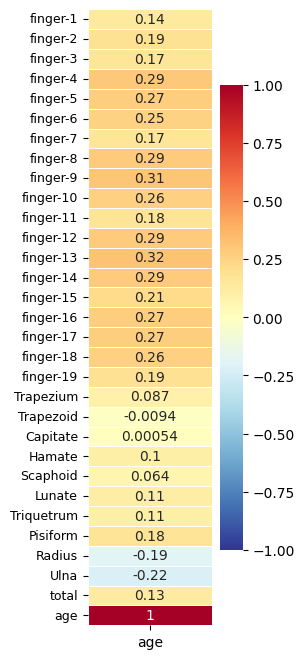

In [141]:
visualize_per_meta('age')

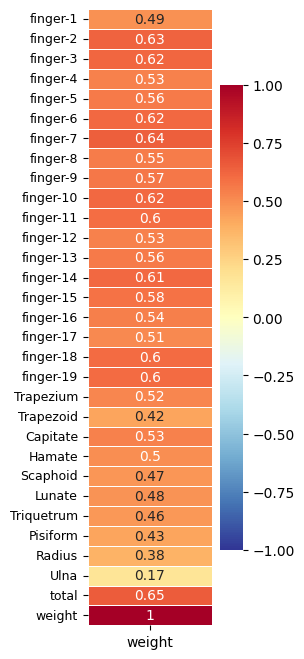

In [142]:
visualize_per_meta('weight')

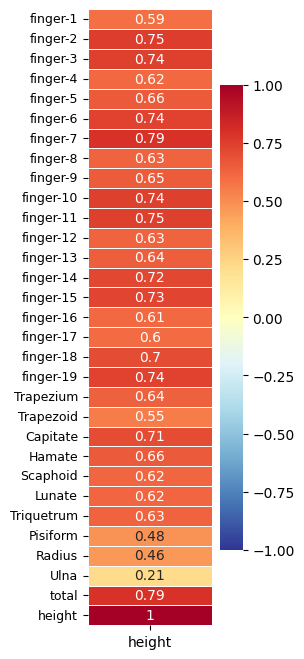

In [143]:
visualize_per_meta('height')

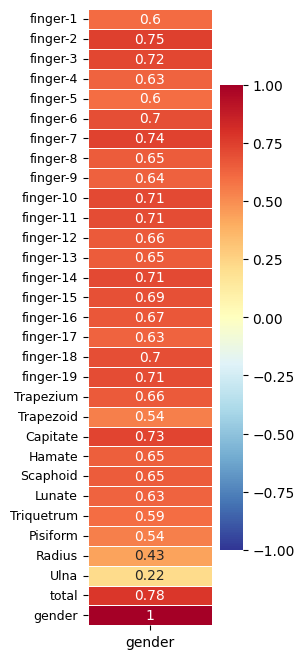

In [144]:
visualize_per_meta('gender')

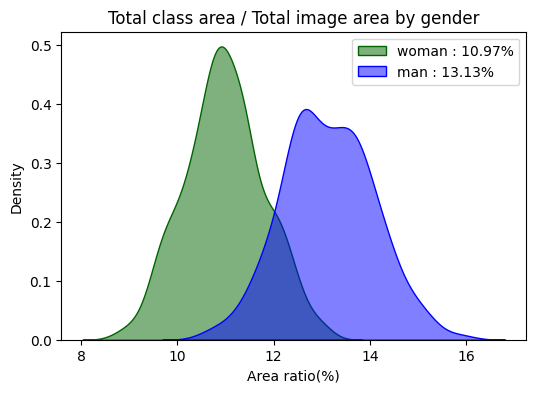

In [ ]:
# 성별에 따른 손 크기
woman_df = pd.DataFrame(numeric_df[numeric_df['gender'] == 0]['total_ratio'])
man_df = pd.DataFrame(numeric_df[numeric_df['gender'] == 1]['total_ratio'])

fig, axes = plt.subplots(figsize=(6, 4))

sns.kdeplot(x='total_ratio', data=woman_df, label=f'woman : {woman_df.mean(axis=0).item():.2f}%', color='darkgreen', alpha=0.5, fill=True, ax=axes)
sns.kdeplot(x='total_ratio', data=man_df, label=f'man : {man_df.mean(axis=0).item():.2f}%', color='blue', alpha=0.5, fill=True, ax=axes)

plt.title('Total class area / Total image area by gender')
plt.xlabel('Area ratio(%)')
plt.legend()
plt.show()

### Analyze Similarity of Both Hands

In [519]:
def get_similarity_rank(df):
    cosine_matrix = cosine_similarity(df.to_numpy())

    diag_np = np.ones((df.shape[0], df.shape[0]))
    np.fill_diagonal(diag_np, 0)

    cosine_matrix = cosine_matrix * diag_np
    similar_index = np.argsort(cosine_matrix, axis=1)

    # 왼손은 오른손과 비교, 오른손은 왼손과 비교
    rank_result = []
    for i in range(df.shape[0]):
        n = 1
        count = 1
        if i % 2 == 0:
            while (similar_index[i, -n] != (i+1)):
                n += 1
                if similar_index[i, -n] % 2 == 1:
                    count += 1
            rank_result.append(count)
        else:
            while (similar_index[i, -n] != (i-1)):
                n += 1
                if similar_index[i, -n] % 2 == 0:
                    count += 1
            rank_result.append(count)
    return rank_result

def visualize_similarity_rank(rank_result):
    plt.figure(figsize=(8, 4))
    counts, bins, patches = plt.hist(rank_result, bins=40,edgecolor='black')
    for i in range(len(counts)):
        if counts[i] == 0:
            continue
        plt.text((bins[i] + bins[i+1]) / 2, counts[i], str(int(counts[i])), 
                ha='center', va='bottom', size=7) 
    plt.xlabel('rank')
    plt.ylabel('count')
    plt.title(f'The rank of similarity of correct hand')
    plt.show()

def get_lower_id(rank_result, limit):
    lower_indices = [i for i, val in enumerate(rank_result) if val >= limit]
    sorted_indices = sorted(lower_indices, key=lambda x: rank_result[x], reverse=True)
    lower_id = []
    for ind in sorted_indices:
        id = merged_df.ID[ind]
        if id not in lower_id: # 중복 제거
            lower_id.append(merged_df.ID[ind])
    return lower_id

In [520]:
# 양손 간 유사도(모든 클래스)
rank_result_all = get_similarity_rank(numeric_df.iloc[:,:30])

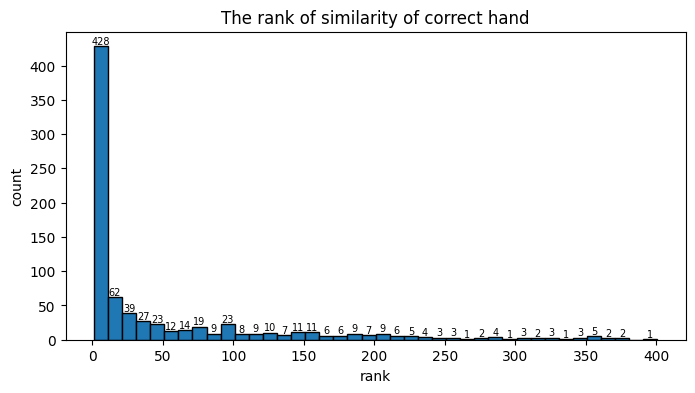

In [521]:
visualize_similarity_rank(rank_result_all)

In [ ]:
# 낮은 rank의 이미지 시각화
lower_id_all = get_lower_id(rank_result_all, 360)
for id in lower_id_all:
    visualize_segmentation(id)

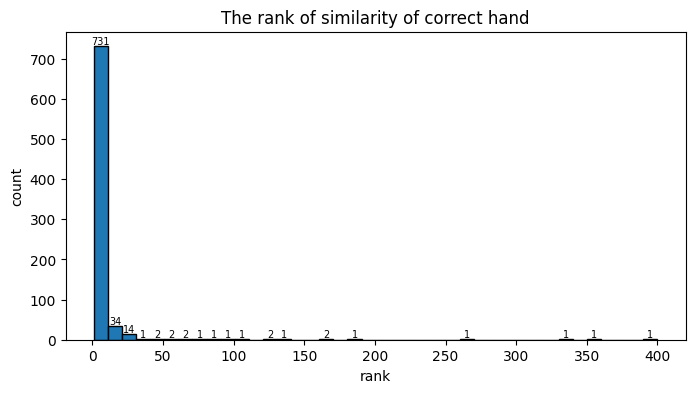

In [523]:
# 양손 간 유사도(손목, total 제외)
rank_result = get_similarity_rank(numeric_df.iloc[:,:27])
visualize_similarity_rank(rank_result)

In [ ]:
# 낮은 rank의 이미지 출력
lower_id = get_lower_id(rank_result, 100)
for id in lower_id:
    visualize_segmentation(id)